<table style="width: 100%;">
  <tr>
    <td style="text-align: left;"><h1 style="font-size: 30px;">Review of dataset</h1></td>
    <td style="text-align: right;"><img src="https://upload.wikimedia.org/wikipedia/commons/e/e6/Logo_Universitat_de_Barcelona.png" alt="University of Barcelona Logo" width="200" /></td>
  </tr>
</table>

# Data Analysis - Second Iteration - Summary

In this second iteration of our data analysis, our primary focus is to improve the performance of the Random Forest model that we previously developed. To achieve this, we will explore various aspects of our data and model. Here are the main areas we will be investigating:

## Areas of Focus

1. **Review Count Thresholds to train the RF** In previouse iterations I chose at random that I would only use accomodations with at least 100 reviews to improve consistency. Now I want to see if I can bring down this number in the spirit of having more training data without compromising the value of the data.

2. **Utilizing Full Location Variable:** We will consider the full location variable to assess whether it provides more valuable information for our model compared to a simplified or reduced representation.

3. **Incorporating Full Amenities Variables:** Instead of using Principal Component Analysis (PCA) on amenities, we will use the full amenities variables to evaluate if this leads to better model performance.

4. **Determine if Text embeddings improve** In the previouse iteration, we used the embeddings of the accomodation description. Now we are going to calculate the embeddings in the same way for the naighbourhood description. After this, we are going to try wether it improves performance or not (Spoilers, it worsens predictive power).


Additionally, we will create custom transformers to make the data processing process more seamless. These custom transformers will assist in efficiently preparing the data for model training and analysis.

Through these investigations, we aim improve the predictive accuracy of the RF model. By considering a more detailed representation of location, amenities, and reviews, we expect to uncover valuable insights that will lead to better results.

Let's begin our exploration and analysis, making use of custom transformers to enhance our data processing workflow and streamline our efforts in enhancing our model's performance.

## Imports and database initialization

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import re 
import seaborn as sns
from scipy import stats

# Eliminate warnings for presentation purpuses
import warnings
warnings.filterwarnings('ignore') #ignore all warnings, very messy
#warnings.filterwarnings('default')
pd.options.mode.chained_assignment = None
from rich import print

#preatty printing
from rich import print
from tabulate import tabulate
from IPython.display import Markdown
from IPython.display import display, HTML
pd.set_option('display.max_colwidth', 100)
from prettytable import PrettyTable
import icecream as ic
import os

import shap
from sklearn.model_selection  import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs('bdd_barcelona/processed/Test-4', exist_ok=True)
os.makedirs('bdd_barcelona/processed/Test-4', exist_ok=True)


In [11]:
insights = pd.read_csv('bdd_barcelona/originals/listings.csv')
reviews = pd.read_csv('bdd_barcelona/originals/reviews.csv')

In [13]:
def filter_accomodation_num_review(bdd, col_name, min_reviews = 100):
    return bdd[bdd[col_name] >= min_reviews]

In [14]:
filtered_insights_50 = filter_accomodation_num_review(insights, 'number_of_reviews', 20)
filtered_insights_100 = filter_accomodation_num_review(insights, 'number_of_reviews', 100)
print(f"When filtering for accomodations with at least 100 reviews, we get {len(filtered_insights_100)} distinct accomodations")
print(f"When filtering for accomodations with at least 50 reviews, we get {len(filtered_insights_50)} distinct accomodations")

When filtering for accomodations with at least 100 reviews, we get 2320 distinct accomodations

When filtering for accomodations with at least 50 reviews, we get 6188 distinct accomodations

In [15]:
display(filtered_insights_50.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [16]:
def describe_dataframe(df):
    # Create an empty list to store the result data
    result_data = []

    # Iterate through the columns of the input DataFrame
    for column_name in df.columns:
        data_type = df[column_name].dtypes  # Get the data type of the column
        example_value = df[column_name].iloc[0]  # Get the first value in the column

        # Append the information as a dictionary to the result list
        result_data.append({'Variable': column_name, 'Data Type': data_type, 'Example Value': example_value})

    # Convert the result list to a DataFrame
    result_df = pd.DataFrame(result_data)

    # Convert the result DataFrame to an HTML table
    html_table = result_df.to_html(classes='table table-striped table-hover', escape=False, index=False)

    display(HTML(html_table))

# Model

## Transformer and model

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# function to only do the 1HOTEncoder in neighbourhood
def encode_neighbourhood(bdd):
    nei_list = ['neighbourhood_group_cleansed','neighbourhood_cleansed']

    # Tranformer
    nei_pipeline = ColumnTransformer([
        ('nei',OneHotEncoder(), nei_list),
    ])

    nei_pipeline.fit(bdd)
    nei_HOT = pd.DataFrame(nei_pipeline.transform(bdd).toarray(), columns = nei_pipeline.get_feature_names_out())
    #print(nei_pipeline.feature_names_in_)
    return pd.concat([bdd, nei_HOT], axis=1)

In [18]:
import pandas as pd
import re
import ast
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import icecream as ic


#-------------------------------------------- CUSTOM TRANSFORMER AMENITIES ---------------------------------------
#-----------------------------------------------------------------------------------------------------------------

class AmenitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encode_dict = {}             # This contains the dictionary of transformations
        self.filtered_amenities_list = [] # This contains the list of unique features ONEHOTENCODED

    def fit(self, X, y=None):
        all_amenities = []

        # Extract and preprocess amenities
        for sublist in X['amenities']:
            real_sublist = ast.literal_eval(sublist)
            for word in real_sublist:
                all_amenities.append(word)

        unique_amenities_list = sorted(set(all_amenities))

        # Compress specific amenities
        patterns_to_compress = [
            ('TV', 'TV'), ('shampoo', 'shampoo'), ('soap', 'soap'), ('parking', 'parking', 'garage'),
            ('exercise', 'gym'), ('stove', 'stove'), ('oven', 'oven'), ('coffee', 'coffee'), ('refrigerator', 'refrigerator'),
            ('books', 'books'), ('pool', 'pool'), ('clothing', 'clothing'), ('Washer', 'washer'), ('conditioner', 'conditioner'),
            ('dryer', 'dryer'), ('backyard', 'backyard'), ('Baby', 'Baby'), ('console', 'console'), ('sound', 'sound'),  
            ('grill', 'grill'), ('fireplace', 'fireplace'), ('Shared hot tub', 'Shared hot tub'), ('hot tub', 'hot tub'), 
            ('beach', 'beach'), ('chair', 'chair'), ('crib', 'crib')
        ]
        self.compress_amenities(unique_amenities_list, 'wifi', 'wifi')
        for pattern in patterns_to_compress:
            label, *patterns = pattern
            self.compress_amenities(self.filtered_amenities_list, label, *patterns)
    
        return self

    def transform(self, X):
        filtered_insight_OHE_2 = X.copy()
        filtered_insight_OHE_2['amenities'] = filtered_insight_OHE_2['amenities'].apply(ast.literal_eval)

        for value in self.filtered_amenities_list:
            appear = False
            if value in self.encode_dict.keys():
                word_filter = self.encode_dict[value]
            else:
                word_filter = [value]
            filtered_insight_OHE_2[value] = filtered_insight_OHE_2.apply(lambda row: 1.0 if self.check_amenities_in_filter(row['amenities'], word_filter) else 0.0, axis=1)

        return filtered_insight_OHE_2

    def compress_amenities(self, amenities_list, label, *patterns):
        pattern = re.compile('|'.join(patterns), re.IGNORECASE)
        var_list = [word for word in amenities_list if pattern.search(word)]
        self.filtered_amenities_list = [amenity for amenity in amenities_list if not pattern.search(amenity)]
        self.filtered_amenities_list.append(label)
        self.encode_dict[label] = var_list

    def check_amenities_in_filter(self, amenities, filter):
        return any(amenity in filter for amenity in amenities)
    def get_feature_names_out(self):
        return self.filtered_amenities_list

# Usage:
#amenities_transformer = AmenitiesTransformer()
#filtered_insight_transformed = amenities_transformer.fit_transform(A)
#features = amenities_transformer.get_feature_names_out()
#print(filtered_insight_transformed)

In [19]:
def describe_dataframe(df):
    # Create an empty list to store the result data
    result_data = []

    # Iterate through the columns of the input DataFrame
    for column_name in df.columns:
        data_type = df[column_name].dtypes  # Get the data type of the column
        example_value = df[column_name].iloc[0]  # Get the first value in the column

        # Append the information as a dictionary to the result list
        result_data.append({'Variable': column_name, 'Data Type': data_type, 'Example Value': example_value})

    # Convert the result list to a DataFrame
    result_df = pd.DataFrame(result_data)

    # Convert the result DataFrame to an HTML table
    html_table = result_df.to_html(classes='table table-striped table-hover', escape=False, index=False)

    display(HTML(html_table))

In [20]:
#---------------------------------------------------------------------------------------------------------
#-------------------------------------------- MAKE ALL TRANSFORMATIONS TO THE DATABASE -------------------
#---------------------------------------------------------------------------------------------------------
def transform_bdd_2(bdd,aditional_num_variables = [], aditional_other_variables = []):
    
    bdd = bdd.dropna(subset=['id'])
    # 3---------------------------------------DROP COLUMNS-----------------------------------------------------
    col_names = ["Unnamed: 0.1","Unnamed: 0","listing_url","scrape_id","last_scraped","source","name"
            "neighborhood_overview","picture_url","host_id","host_url","host_name","host_since",
            "host_location","host_about","host_response_time","host_response_rate","host_acceptance_rate",
            "host_thumbnail_url","host_picture_url","host_neighbourhood","host_verifications","license","bathrooms_text","instant_bookable",
            "neighbourhood","neighbourhood_cleansed","neighborhood_overview","name","has_availability","calendar_last_scraped"]

    columns_to_drop = [col for col in col_names if col in bdd.columns]
    bdd.drop(columns=columns_to_drop, inplace=True)
    # 4------------------------------------FORMATTING BOOLEAN CLUMNS-------------------------------------------------------
    replacement_dict = {"f": 0.0, "t": 1.0}
    columns_to_replace = ["host_is_superhost","host_has_profile_pic","host_identity_verified"]
    bdd[columns_to_replace] = bdd[columns_to_replace].replace(replacement_dict)
    # 5------------------------------------FORMATTING PRICE----------------------------------------------
    try:
        bdd["price"] = bdd["price"].apply(lambda x: float(x.replace("$", "").replace(",", "")))
    except (AttributeError, ValueError) as e:
        print("Price already transformed to float")
        
    # 6-----------------------------------FORMAT DATES--------------------------------------------------
    
    date_features = ['first_review','last_review']
    for col in date_features:
        try:
            bdd[col] = pd.to_datetime(bdd[col], format="%Y-%m-%d")
            bdd[col] = (bdd[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
        except (ValueError, TypeError) as e:
            print("Date already tranformed")

    
    # 7-----------------------------------Tranformer-------------------------------------------------------------
    hot_features = ['neighbourhood_group_cleansed','neighbourhood_cleansed',"property_type","room_type"]
    num_features = ['host_listings_count','host_total_listings_count','host_has_profile_pic','host_identity_verified',
    'accommodates','bedrooms','beds','price','minimum_nights','maximum_nights',
    'minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm','availability_30','availability_60','availability_90','availability_365','number_of_reviews',
    'number_of_reviews_ltm','number_of_reviews_l30d','calculated_host_listings_count','calculated_host_listings_count_entire_homes',
    'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','first_review','last_review',"size"]
    
    other_features = ['host_is_superhost', 'calendar_updated','amenities','id','sentiment'] 
    
    #this function will ensure that all features that we are going to be processing, are in the current database       
    def filtes_real_features(bdd, features):
        col_names = list(bdd.columns)
        real_features = [elem for elem in features if elem in col_names]

        return np.array(real_features)
    hot_features = filtes_real_features(bdd,hot_features)
    num_features = filtes_real_features(bdd,num_features)
    other_features = filtes_real_features(bdd,other_features)
    
    if 'sentiment' not in list(bdd.columns):
        bdd = bdd.assign(sentiment=0)
    
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler',StandardScaler())        
    ])
    
    def identity(df):
        return df
    iden = FunctionTransformer(identity)
    
    pipe = ColumnTransformer([
        ('1HOT',OneHotEncoder(), hot_features),
        ('numbers',num_pipeline, num_features),
        ('identity',iden, other_features)
    ],
        sparse_threshold=0 )

    pipe.fit(bdd)
    
    bdd = pd.DataFrame(pipe.transform(bdd), columns = list(pipe.named_transformers_['1HOT'].get_feature_names_out()) + list(pipe.named_transformers_['numbers'].get_feature_names_out()) + list(other_features))
    bdd = bdd.dropna(subset=['id'])
    
    amenities_transformer = AmenitiesTransformer()
    bdd = amenities_transformer.fit_transform(bdd)
    
    bdd.fillna(0, inplace=True)
    bdd.drop(columns=['id','amenities'], inplace=True)
    return bdd

In [21]:
## --------------------------------------------TEXT EMBEDDING: BERT-------------------------------------------------
## -------------------------------------------USED TO DESCRIBE THE DESCRIPTION--------------------------------------
## Call only if needed, we will do it once and then save the database, after the transformations, we will append the embeded description
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA

def calculate_embedings(bdd,column_to_embed,num_min_reviews = 100):
    # Load the pre-trained BERT model and tokenizer (you need to install transformers)
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertModel.from_pretrained(model_name)

    text_column = bdd[column_to_embed]

    # Initialize an empty list to store the embeddings
    embeddings = []

    # Loop through each element in the column and embed it
    for text in text_column:
        # Tokenize and convert the sentence to input format
        #print(type(text))
        if type(text)==float:
            text = ""
        if text == np.nan:
            text = ""
        tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt")

        # Get the sentence embedding
        with torch.no_grad():
            outputs = model(**tokens)
            sentence_embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

        # Append the embedding to the list
        embeddings.append(sentence_embedding)

    # Convert the list of embeddings to a NumPy array
    embeddings_array = np.array(embeddings)

    # train and fit the PCA for description embeded
    embeddings_array_t = embeddings_array

    variance = 0.95 

    emb = embeddings_array_t.copy()

    pca_description = PCA(n_components = variance)
    compressed = pca_description.fit_transform(emb)

    compressed = compressed.T

    print(f"Amound of components from using BERT embedding: {len(embeddings_array_t.T)}")
    print(f"Amound of components from using BERT embedding and using a PCA: {len(compressed)}")


    description_EMB_PCA = pd.DataFrame()
    description_EMB = pd.DataFrame()

    column_titles = [f'{column_to_embed}_{i}' for i in range(len(compressed))]
    for i in range(len(compressed)):
        description_EMB_PCA[column_titles[i]] = compressed[i]

    column_titles = [f'{column_to_embed}_{i}' for i in range(len(embeddings_array_t.T))]
    for i in range(len(embeddings_array_t.T)):
        description_EMB[column_titles[i]] = embeddings_array_t.T[i]

    #display(final_bdd_PCA.shape)
    #display(final_bdd.shape)
    
    #Save the embedings because it is costrly to run this function
    description_EMB_PCA.to_csv(f'bdd_barcelona/processed/Test-4/{column_to_embed}_{num_min_reviews}_EMB_PCA.csv', index=False)
    description_EMB.to_csv(f'bdd_barcelona/processed/Test-4/{column_to_embed}_{num_min_reviews}_EMB.csv', index=False)
    
    return (description_EMB_PCA,description_EMB)

In [22]:
import os

def load_description_embeddings(bdd,column_to_embed, num_min_reviews = 100):

    document_name_PCA = f'bdd_barcelona/processed/Test-4/{column_to_embed}_{num_min_reviews}_EMB_PCA.csv'
    document_name = f'bdd_barcelona/processed/Test-4/{column_to_embed}_{num_min_reviews}_EMB.csv'
    # Check if the document exists in the folder
    if os.path.exists( document_name_PCA) :
        print(f"Loading {column_to_embed} Embeddings")
        description_EMB_PCA = pd.read_csv(document_name_PCA)
        description_EMB = pd.read_csv(document_name)
        print('Loaded')

    else:
        print(f"Calculating Full {column_to_embed} Embeddings")
        description_EMB_PCA, description_EMB = calculate_embedings(bdd,column_to_embed)
        print("Calculated")
    try:
        columns_to_drop = [col for col in [{column_to_embed}] if col in bdd.columns] # per seguretat
        bdd.drop(columns=columns_to_drop, inplace=True)
    except:
        pass
    return (description_EMB_PCA,description_EMB)


In [23]:
def bdd_premodel(df,directory = "bdd_barcelona/AB/normal",case = 0, recalculate = False, num_min_reviews = 100): 
    outpus_types = ['review_scores_rating', 'review_scores_accuracy',
           'review_scores_cleanliness', 'review_scores_checkin',
           'review_scores_communication', 'review_scores_location',
           'review_scores_value',]
    print("-----------------------------PREMODEL: START -------------------------")
    doc_name_A = f"{directory}/A.csv"
    doc_name_B = f"{directory}/B.csv"
    # Check if the document exists in the folder
    if os.path.exists(doc_name_A) & (not recalculate):
        print("-----------------------------PREMODEL: Already calculated -------------------------")
        A = pd.read_csv(doc_name_A)
        B = pd.read_csv(doc_name_B)
        print("-----------------------------PREMODEL: LOADED -------------------------")
    else:
        print("-----------------------------PREMODEL: Not found, satrt calculations -------------------------")
        A = df.drop(columns=outpus_types, axis=1)
        B = df[outpus_types].copy()
        print(f"len(A) = {len(A)}")
        print(f"len(B) = {len(B)}")
        print(f"Shape of A before transforming: {A.shape}")
        A = transform_bdd_2(A)
        # Cal comprovar si és millor amb o sense descriptió
        if case == 1:
            description_EMB_PCA,description_EMB = load_description_embeddings(df,'description',num_min_reviews)
            A = pd.concat([A, description_EMB_PCA], axis=1)
        # Cal comprovar si és millor amb o sense nei_overview
        if case == 2:
            description_EMB_PCA,description_EMB = load_description_embeddings(df,'neighborhood_overview',num_min_reviews)
            A = pd.concat([A, description_EMB_PCA], axis=1)
        if case == 3:
            description_EMB_PCA,description_EMB = load_description_embeddings(df,'description',num_min_reviews)
            A = pd.concat([A, description_EMB_PCA], axis=1)
            description_EMB_PCA,description_EMB = load_description_embeddings(df,'neighborhood_overview',num_min_reviews)
            A = pd.concat([A, description_EMB_PCA], axis=1)
        print(f"Shape of A after full transforming: {A.shape}")
        print("Now the database A is ready to be used")
        print("---------------------------PREMODEL: FINISH ---------------------------")
        
        if not os.path.exists(directory):
            os.makedirs(directory)
        A.to_csv(doc_name_A, index = False)
        B.to_csv(doc_name_B, index = False)
    
    return (A,B)

In [24]:
#A.to_csv("AB/normal/A.csv", index = False)
#B.to_csv("AB/normal/B.csv", index = False)

In [198]:
filtered_insights_100 = filter_accomodation_num_review(insights, 'number_of_reviews', 100)
A,B = bdd_premodel(filtered_insights_100,"bdd_barcelona/AB/base_with_descrip",case = 1,recalculate = True)

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 2320

len(B) = 2320

Shape of A before transforming: (2320, 68)

Calculating Full description Embeddings

Amound of components from using BERT embedding: 768

Amound of components from using BERT embedding and using a PCA: 133

Calculated

Shape of A after full transforming: (2320, 363)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

In [166]:
print(f"len(A) = {len(A)}")
print(f"len(B) = {len(B)}")

len(A) = 5678

len(B) = 2320

## Model Making

In [29]:
import pickle
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def show_pretty_r2_table(test,pred,min_reviews,results_df = None):
    table = PrettyTable()
    table.field_names = ["Model", "Score type", "R^2", "MSE"]
    try:
        if results_df is None:
            results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
    except Exception as e:
        pass
    rows_to_append = []
    total_r2_score = 0
    for i in range(7):
        mse = mean_squared_error(test.values.T[i], pred.T[i])
        r2 = r2_score(test.values.T[i], pred.T[i])
        table.add_row([f"RF >{min_reviews}revi", test.columns[i], f"{r2:.4f}", f"{mse:.4f}"])
        rows_to_append.append({"Model": f"RF >{min_reviews}revi",
                               "Score type": test.columns[i],
                               "R^2": r2,
                               "MSE": mse})
        total_r2_score += r2
    print(table)
    print(total_r2_score)
    return pd.concat([results_df, pd.DataFrame(rows_to_append)], ignore_index=True, axis = 0)

def model_testing(A,B,name=25,results_df = None,recalculate=False):
    
    directory = fr'bdd_barcelona/models/{name}'
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = os.path.join(directory, f"random_forest_model_{name}.pkl")
    score_type = 'review_scores_location'
    #if results_df == None:
        #results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
    print("-------------- MODEL TRAINING: START ----------------------------")
    A.fillna(A.mean(), inplace=True)
    B.fillna(B.mean(), inplace=True)
    A.columns = A.columns.astype(str)
    A.columns = [str(col) for col in A.columns]
    B.columns = B.columns.astype(str)
    B.columns = [str(col) for col in B.columns]
    # Split the dataset into training and test sets (e.g., 80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)

    
    regressor = RandomForestRegressor(n_estimators=100,random_state=0)

    regressor.fit(X_train, y_train)
    
    # Save the trained model to a file
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(regressor, pickle_file)
        
    print("-------------- MODEL TRAINING: FINISH ----------------------------")
    y_pred_rf = regressor.predict(X_test)

    results_df = show_pretty_r2_table(y_test,y_pred_rf,name,results_df)
    results_df.to_csv(fr'bdd_barcelona/models/{name}/results_{name}.csv', index=False)
    return results_df


In [26]:
"""X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
display(y_test.head(1))"""

'X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)\ndisplay(y_test.head(1))'

In [199]:
num_reviews = 100
filtered_insights = filter_accomodation_num_review(insights, 'number_of_reviews', num_reviews)
A,B = bdd_premodel(filtered_insights,"bdd_barcelona/AB/base_with_descrip",case = 1)
results_df = model_testing(A,B,num_reviews,recalculate=True) 

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Already calculated -------------------------

-----------------------------PREMODEL: LOADED -------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------------+-----------------------------+--------+--------+
|    Model    |          Score type         |  R^2   |  MSE   |
+-------------+-----------------------------+--------+--------+
| RF >100revi |     review_scores_rating    | 0.4476 | 0.0201 |
| RF >100revi |    review_scores_accuracy   | 0.4080 | 0.0150 |
| RF >100revi |  review_scores_cleanliness  | 0.3036 | 0.0263 |
| RF >100revi |    review_scores_checkin    | 0.5668 | 0.0100 |
| RF >100revi | review_scores_communication | 0.4685 | 0.0113 |
| RF >100revi |    review_scores_location   | 0.1995 | 0.0126 |
| RF >100revi |     review_scores_value     | 0.4315 | 0.0177 |
+-------------+-----------------------------+--------+--------+

2.825460918524952

## FINDING OUT THE AMOUND OF MINIMUM REVIEWS TO TRAIN THE RF

In [30]:
results_df = pd.DataFrame(columns=["Model", "Score type", "R^2", "MSE"])
def find_optimal_min_review(results_df):
    for i in [200,150,100,80,50,30,25,20,15,10,5]:
        filtered_insights = filter_accomodation_num_review(insights, 'number_of_reviews', i)
        A,B = bdd_premodel(filtered_insights,recalculate = True)
        results_df = model_testing(A,B,i,results_df) 
    return results_df
results_df = find_optimal_min_review(results_df)
display(results_df)

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 969

len(B) = 969

Shape of A before transforming: (969, 68)

Shape of A after full transforming: (969, 209)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------------+-----------------------------+--------+--------+
|    Model    |          Score type         |  R^2   |  MSE   |
+-------------+-----------------------------+--------+--------+
| RF >200revi |     review_scores_rating    | 0.5355 | 0.0118 |
| RF >200revi |    review_scores_accuracy   | 0.4944 | 0.0093 |
| RF >200revi |  review_scores_cleanliness  | 0.4073 | 0.0162 |
| RF >200revi |    review_scores_checkin    | 0.4416 | 0.0064 |
| RF >200revi | review_scores_communication | 0.4511 | 0.0073 |
| RF >200revi |    review_scores_location   | 0.2998 | 0.0088 |
| RF >200revi |     review_scores_value     | 0.4993 | 0.0114 |
+-------------+-----------------------------+--------+--------+

3.1289443820979916

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 1486

len(B) = 1486

Shape of A before transforming: (1486, 68)

Shape of A after full transforming: (1486, 219)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------------+-----------------------------+--------+--------+
|    Model    |          Score type         |  R^2   |  MSE   |
+-------------+-----------------------------+--------+--------+
| RF >150revi |     review_scores_rating    | 0.5137 | 0.0150 |
| RF >150revi |    review_scores_accuracy   | 0.4762 | 0.0106 |
| RF >150revi |  review_scores_cleanliness  | 0.3944 | 0.0177 |
| RF >150revi |    review_scores_checkin    | 0.5437 | 0.0092 |
| RF >150revi | review_scores_communication | 0.4980 | 0.0095 |
| RF >150revi |    review_scores_location   | 0.2425 | 0.0151 |
| RF >150revi |     review_scores_value     | 0.4968 | 0.0139 |
+-------------+-----------------------------+--------+--------+

3.1652877875174483

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 2320

len(B) = 2320

Shape of A before transforming: (2320, 68)

Shape of A after full transforming: (2320, 230)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-------------+-----------------------------+--------+--------+
|    Model    |          Score type         |  R^2   |  MSE   |
+-------------+-----------------------------+--------+--------+
| RF >100revi |     review_scores_rating    | 0.5014 | 0.0181 |
| RF >100revi |    review_scores_accuracy   | 0.4594 | 0.0137 |
| RF >100revi |  review_scores_cleanliness  | 0.3728 | 0.0237 |
| RF >100revi |    review_scores_checkin    | 0.6150 | 0.0089 |
| RF >100revi | review_scores_communication | 0.5203 | 0.0102 |
| RF >100revi |    review_scores_location   | 0.3194 | 0.0107 |
| RF >100revi |     review_scores_value     | 0.4953 | 0.0157 |
+-------------+-----------------------------+--------+--------+

3.2836093819913432

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 2782

len(B) = 2782

Shape of A before transforming: (2782, 68)

Shape of A after full transforming: (2782, 233)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------+-----------------------------+--------+--------+
|   Model    |          Score type         |  R^2   |  MSE   |
+------------+-----------------------------+--------+--------+
| RF >80revi |     review_scores_rating    | 0.5298 | 0.0166 |
| RF >80revi |    review_scores_accuracy   | 0.4947 | 0.0119 |
| RF >80revi |  review_scores_cleanliness  | 0.4015 | 0.0226 |
| RF >80revi |    review_scores_checkin    | 0.5655 | 0.0085 |
| RF >80revi | review_scores_communication | 0.4888 | 0.0095 |
| RF >80revi |    review_scores_location   | 0.2458 | 0.0123 |
| RF >80revi |     review_scores_value     | 0.5063 | 0.0153 |
+------------+-----------------------------+--------+--------+

3.2323948404848344

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 3974

len(B) = 3974

Shape of A before transforming: (3974, 68)

Shape of A after full transforming: (3974, 237)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------+-----------------------------+--------+--------+
|   Model    |          Score type         |  R^2   |  MSE   |
+------------+-----------------------------+--------+--------+
| RF >50revi |     review_scores_rating    | 0.5356 | 0.0213 |
| RF >50revi |    review_scores_accuracy   | 0.4624 | 0.0174 |
| RF >50revi |  review_scores_cleanliness  | 0.3792 | 0.0295 |
| RF >50revi |    review_scores_checkin    | 0.6379 | 0.0129 |
| RF >50revi | review_scores_communication | 0.5480 | 0.0128 |
| RF >50revi |    review_scores_location   | 0.3883 | 0.0155 |
| RF >50revi |     review_scores_value     | 0.5290 | 0.0189 |
+------------+-----------------------------+--------+--------+

3.4804964818622577

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 5225

len(B) = 5225

Shape of A before transforming: (5225, 68)

Shape of A after full transforming: (5225, 243)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------+-----------------------------+--------+--------+
|   Model    |          Score type         |  R^2   |  MSE   |
+------------+-----------------------------+--------+--------+
| RF >30revi |     review_scores_rating    | 0.5111 | 0.0248 |
| RF >30revi |    review_scores_accuracy   | 0.4419 | 0.0219 |
| RF >30revi |  review_scores_cleanliness  | 0.4114 | 0.0305 |
| RF >30revi |    review_scores_checkin    | 0.5991 | 0.0165 |
| RF >30revi | review_scores_communication | 0.5052 | 0.0170 |
| RF >30revi |    review_scores_location   | 0.2694 | 0.0167 |
| RF >30revi |     review_scores_value     | 0.4900 | 0.0258 |
+------------+-----------------------------+--------+--------+

3.228073661654222

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 5678

len(B) = 5678

Shape of A before transforming: (5678, 68)

Shape of A after full transforming: (5678, 244)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------+-----------------------------+--------+--------+
|   Model    |          Score type         |  R^2   |  MSE   |
+------------+-----------------------------+--------+--------+
| RF >25revi |     review_scores_rating    | 0.5265 | 0.0264 |
| RF >25revi |    review_scores_accuracy   | 0.4774 | 0.0231 |
| RF >25revi |  review_scores_cleanliness  | 0.3977 | 0.0382 |
| RF >25revi |    review_scores_checkin    | 0.6200 | 0.0175 |
| RF >25revi | review_scores_communication | 0.5170 | 0.0184 |
| RF >25revi |    review_scores_location   | 0.3510 | 0.0191 |
| RF >25revi |     review_scores_value     | 0.5274 | 0.0272 |
+------------+-----------------------------+--------+--------+

3.4169842569614306

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 6188

len(B) = 6188

Shape of A before transforming: (6188, 68)

Shape of A after full transforming: (6188, 248)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------+-----------------------------+--------+--------+
|   Model    |          Score type         |  R^2   |  MSE   |
+------------+-----------------------------+--------+--------+
| RF >20revi |     review_scores_rating    | 0.5247 | 0.0268 |
| RF >20revi |    review_scores_accuracy   | 0.4971 | 0.0211 |
| RF >20revi |  review_scores_cleanliness  | 0.3819 | 0.0389 |
| RF >20revi |    review_scores_checkin    | 0.5716 | 0.0198 |
| RF >20revi | review_scores_communication | 0.4873 | 0.0179 |
| RF >20revi |    review_scores_location   | 0.2852 | 0.0221 |
| RF >20revi |     review_scores_value     | 0.5276 | 0.0264 |
+------------+-----------------------------+--------+--------+

3.275538984801669

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 6903

len(B) = 6903

Shape of A before transforming: (6903, 68)

Shape of A after full transforming: (6903, 256)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------+-----------------------------+--------+--------+
|   Model    |          Score type         |  R^2   |  MSE   |
+------------+-----------------------------+--------+--------+
| RF >15revi |     review_scores_rating    | 0.5424 | 0.0285 |
| RF >15revi |    review_scores_accuracy   | 0.4855 | 0.0259 |
| RF >15revi |  review_scores_cleanliness  | 0.4313 | 0.0354 |
| RF >15revi |    review_scores_checkin    | 0.5698 | 0.0206 |
| RF >15revi | review_scores_communication | 0.5015 | 0.0196 |
| RF >15revi |    review_scores_location   | 0.2807 | 0.0239 |
| RF >15revi |     review_scores_value     | 0.5211 | 0.0307 |
+------------+-----------------------------+--------+--------+

3.332167320480842

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 7892

len(B) = 7892

Shape of A before transforming: (7892, 68)

Shape of A after full transforming: (7892, 263)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+------------+-----------------------------+--------+--------+
|   Model    |          Score type         |  R^2   |  MSE   |
+------------+-----------------------------+--------+--------+
| RF >10revi |     review_scores_rating    | 0.5213 | 0.0349 |
| RF >10revi |    review_scores_accuracy   | 0.4669 | 0.0329 |
| RF >10revi |  review_scores_cleanliness  | 0.4188 | 0.0479 |
| RF >10revi |    review_scores_checkin    | 0.5211 | 0.0259 |
| RF >10revi | review_scores_communication | 0.4680 | 0.0253 |
| RF >10revi |    review_scores_location   | 0.3029 | 0.0259 |
| RF >10revi |     review_scores_value     | 0.5147 | 0.0360 |
+------------+-----------------------------+--------+--------+

3.213750475422092

-----------------------------PREMODEL: START -------------------------

-----------------------------PREMODEL: Not found, satrt calculations -------------------------

len(A) = 9619

len(B) = 9619

Shape of A before transforming: (9619, 68)

Shape of A after full transforming: (9619, 266)

Now the database A is ready to be used

---------------------------PREMODEL: FINISH ---------------------------

-------------- MODEL TRAINING: START ----------------------------

-------------- MODEL TRAINING: FINISH ----------------------------

+-----------+-----------------------------+--------+--------+
|   Model   |          Score type         |  R^2   |  MSE   |
+-----------+-----------------------------+--------+--------+
| RF >5revi |     review_scores_rating    | 0.3576 | 0.0633 |
| RF >5revi |    review_scores_accuracy   | 0.3568 | 0.0547 |
| RF >5revi |  review_scores_cleanliness  | 0.3136 | 0.0665 |
| RF >5revi |    review_scores_checkin    | 0.4281 | 0.0444 |
| RF >5revi | review_scores_communication | 0.3945 | 0.0450 |
| RF >5revi |    review_scores_location   | 0.2224 | 0.0394 |
| RF >5revi |     review_scores_value     | 0.3663 | 0.0692 |
+-----------+-----------------------------+--------+--------+

2.439302091143442

,Model,Score type,R^2,MSE
0,RF >200revi,review_scores_rating,0.535487,0.011828
1,RF >200revi,review_scores_accuracy,0.494394,0.009304
2,RF >200revi,review_scores_cleanliness,0.407269,0.016224
3,RF >200revi,review_scores_checkin,0.441622,0.006426
4,RF >200revi,review_scores_communication,0.451119,0.007284
...,...,...,...,...
72,RF >5revi,review_scores_cleanliness,0.313645,0.066474
73,RF >5revi,review_scores_checkin,0.428107,0.044374
74,RF >5revi,review_scores_communication,0.394495,0.045043
75,RF >5revi,review_scores_location,0.222364,0.039448


In [33]:
results_df.to_csv('bdd_barcelona/processed/results_min_rev.csv', index=False)

## MODEL TRAINING

In [43]:
import pickle
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


def load_rf_model(filtered_insights, name = 'latest',recalculate = False):
    
    directory = fr'bdd_barcelona/models/{name}'   
    model_path = os.path.join(directory, f'random_forest_model_{name}.pkl')      
           
    # Check if the document exists in the folder
    if os.path.exists(model_path) & (not recalculate):
        print("-----------------------------Model Found-----------------------------")
        with open(model_path, 'rb') as file:
            loaded_model = pickle.load(file)
        A = pd.read_csv(fr'{directory}/A.csv')
        B = pd.read_csv(fr'{directory}/B.csv')
        results_df = pd.read_csv(fr'{directory}/results_{name}.csv')
        print('----------------------------Model Loaded-----------------------------')

    else:
        print("--------------------------Model Not Found----------------------------")
        #filtered_insights = filter_accomodation_num_review(insight_bdd, 'number_of_reviews', min_reviews)
        A,B = bdd_premodel(filtered_insights,f"{directory}",0,recalculate)
        results_df = model_testing(A,B,name) 
        with open(model_path, 'rb') as file:
            loaded_model = pickle.load(file)
        print("-----------------------------Model Loaded----------------------------")
        
    return (loaded_model,A,B,results_df)

In [45]:
min_reviews = 25
sentiment = True
recalculate = False
filtered_insights = filter_accomodation_num_review(insights, 'number_of_reviews', min_reviews)

# Train/load model
model,A,B,results_df = load_rf_model(filtered_insights,25,recalculate)
display(model)

# Make predictions
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=42)
y_pred_rf = model.predict(X_test)

-----------------------------Model Found-----------------------------

----------------------------Model Loaded-----------------------------

RandomForestRegressor(random_state=0)

## RESULT VISUALIZATION

In [46]:
def visualise_outcom(test, pred):
   
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # Scatter plot of y_test vs y_pred
    ax1 = axes[0]
    ax1.scatter(test, pred, marker='o', color='blue', alpha=0.5)
    ax1.set_xlabel("True Values (test)")
    ax1.set_ylabel("Predicted Values (pred)")
    ax1.set_title("Scatter Plot of True vs Predicted Values")
    ax1.set_ylim(1, 5)
    ax1.set_xlim(1, 5)

    # Sort the values for a smoother line plot
    sorted_indices = np.argsort(test)
    y_test_sorted = test[sorted_indices]
    y_pred_sorted = pred[sorted_indices]

    # Line plot of y_test vs y_pred
    ax2 = axes[1]
    ax2.plot(range(len(test)), y_test_sorted, label="True Values (test)", marker='o', linestyle='-')
    ax2.plot(range(len(pred)), y_pred_sorted, label="Predicted Values (pred)", marker='x', linestyle='--')
    ax2.set_xlabel("Data Points")
    ax2.set_ylabel("Values")
    ax2.set_title("Line Plot of True vs Predicted Values")
    ax2.legend(loc='upper left')

    # Adjust layout
    plt.tight_layout()

    # Show the combined figure
    plt.show()

review_scores_rating

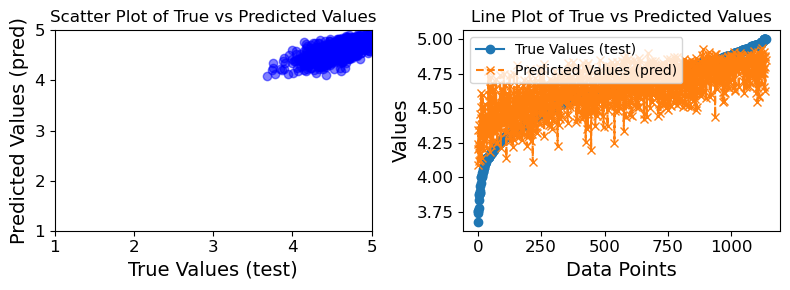

review_scores_accuracy

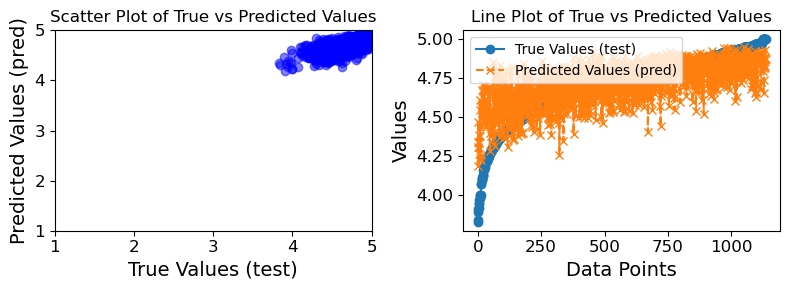

review_scores_cleanliness

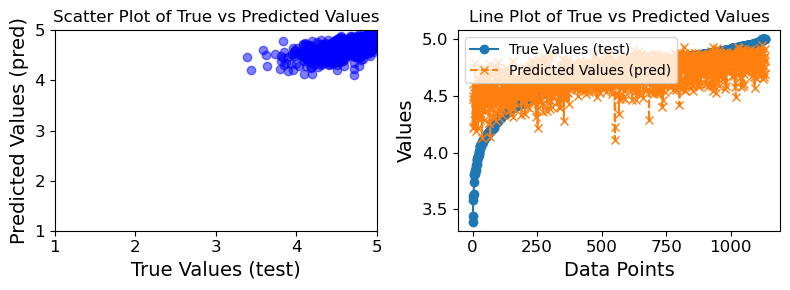

review_scores_checkin

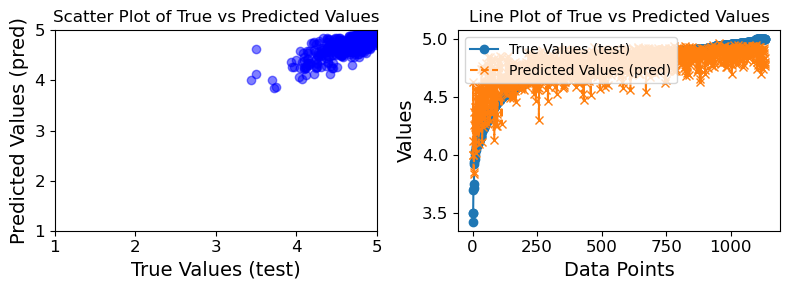

review_scores_communication

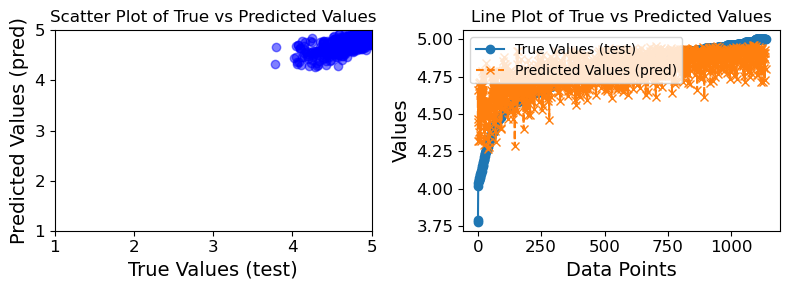

review_scores_location

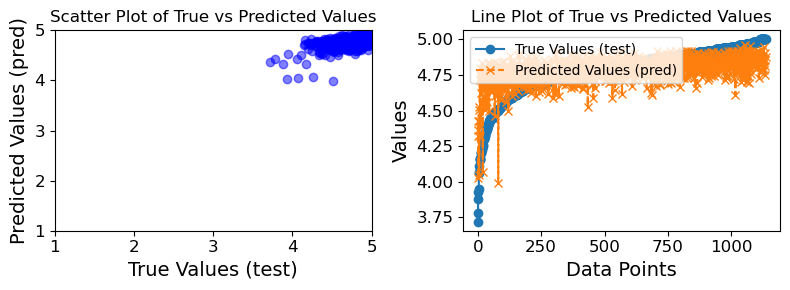

review_scores_value

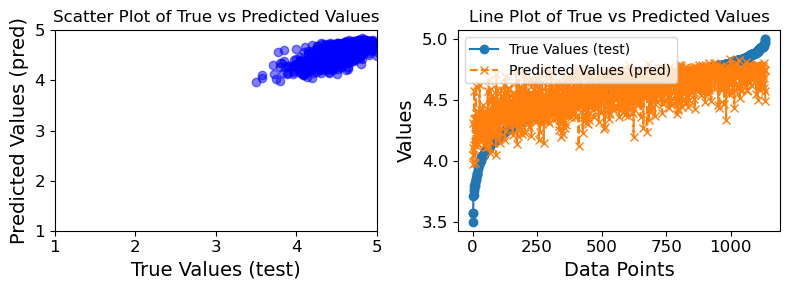

In [47]:
for i in range(7):
    print(f"{y_train.columns[i]}")
    visualise_outcom(y_test.values.T[i], y_pred_rf.T[i])

In [24]:
def reslduals(y_test,y_pred,index):
    # Calculate the residuals
    residuals = y_test - y_pred

    # Create a figure with two subplots: residual error plot and distribution plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Residual Error Plot
    ax1.scatter(x=y_pred, y=residuals, color='b', marker='o', alpha=0.4, label="y_pred")
    ax1.scatter(x=y_test, y=residuals, color='g', marker='o', alpha=0.4, label = "y_test")
    ax1.set_title("Residual Error Plot")
    ax1.set_xlabel("y Values")
    ax1.set_ylabel("Residuals")
    ax1.axhline(y=0, color='r', linestyle='-')
    ax1.legend()

    # Distribution Plot
    sns.histplot(y_pred.T[index], kde=False, ax=ax2,alpha=0.5, color='g',label='y_pred')
    sns.histplot(y_test.T[index], kde=False, ax=ax2,alpha=0.5, color='b', label='y_test')
    ax2.set_title("Residuals Distribution")
    ax2.set_xlabel("Residuals")
    ax2.legend()

    plt.tight_layout()
    plt.show()

review_scores_cleanliness:Residual plots for Randm Forest

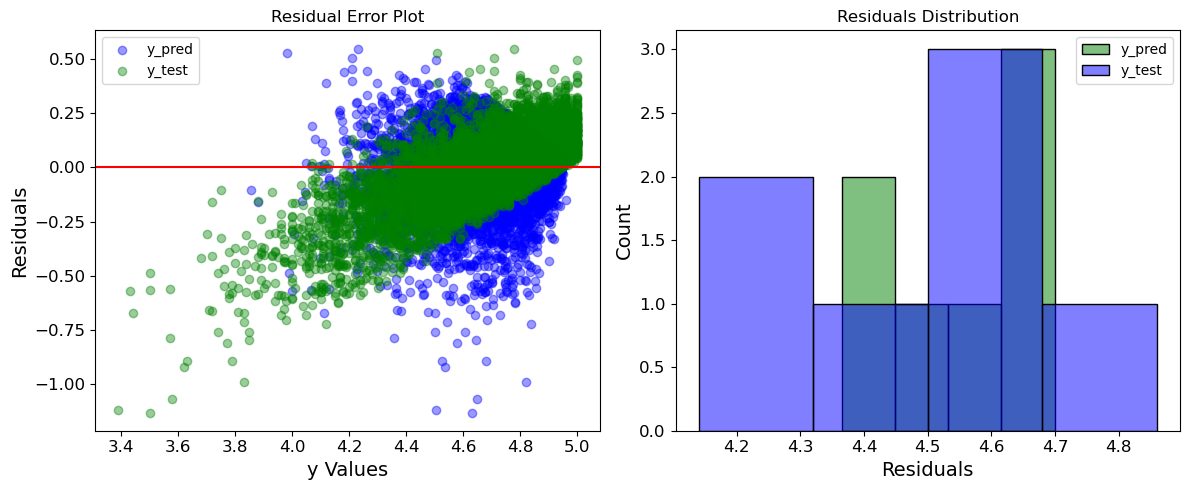

In [29]:
i = 2
print(f"{y_train.columns[i]}:Residual plots for Randm Forest")
reslduals(y_test.values.T,y_pred_rf.T,i)

## EXPLAINABILITY

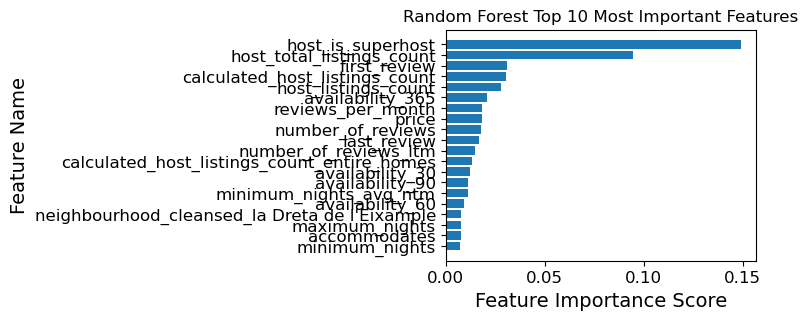

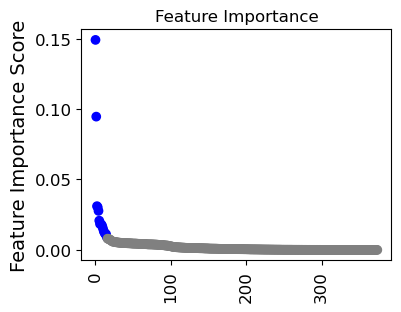

In [30]:
data = {'Name': X_train.columns, 'Score': model.feature_importances_}
df = pd.DataFrame(data)
df = df.sort_values(by='Score', ascending=False)
top_10 = df.head(20)

# Plot a bar chart for the top 10 features
plt.figure(figsize=(4, 3))
plt.barh(top_10['Name'], top_10['Score'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature Name')
plt.title('Random Forest Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()

x = [i for i in range(len(df['Score']))]
colors = ['grey' if score < 0.009 else 'blue' for score in df['Score']]
plt.figure(figsize=(4, 3))
plt.scatter(x, df['Score'], c=colors, marker='o')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance')
plt.xticks( rotation=90)  # Set x-axis labels and rotate for better readability
plt.show()

In [21]:
import shap
import pickle
import os
import json
        
def save_results(data,name = "latest",shap = ""):
    
    # Check if the directorys exist, if not, create them
    directory = fr'models/{name}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    file_path = os.path.join(directory, fr'{name}{shap}.json')
    
    with open(file_path, 'wb') as pickle_file:
        pickle.dump(data, pickle_file)
        
def load_results(name = "latest", shap = ""):
    doc_name = fr'models/{algo}/{name}{shap}.json'
    with open(doc_name, 'rb') as pickle_file:
        results = pickle.load(pickle_file)
    return results

x_sub = shap.sample(X_train,100)
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
save_results(shap_values,"latest","_shap")

 12%|==                  | 931/7952 [01:30<11:18]       

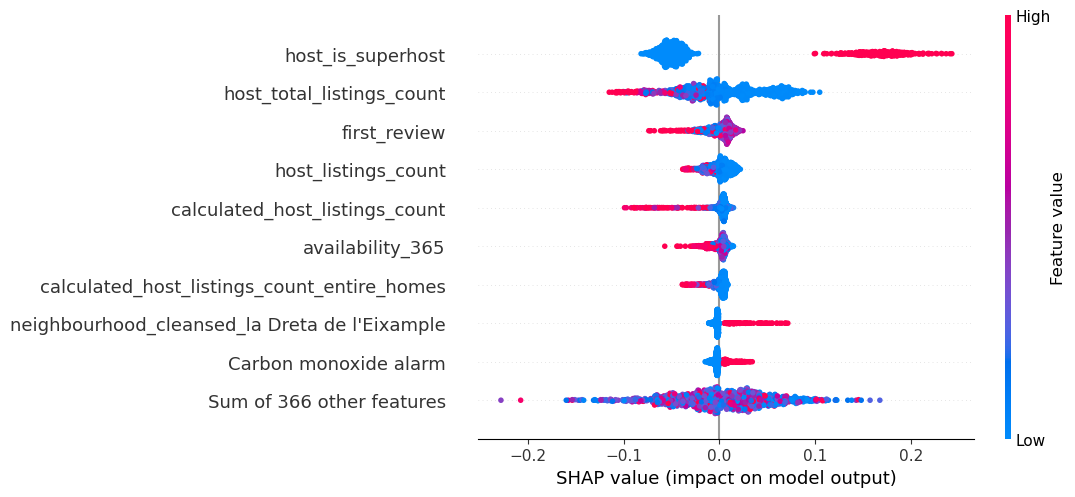

In [56]:
shap.plots.beeswarm(shap_values[:,:,0])